In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

### Random Classification Trees (Single Branch per Data Point)

Unlike in section 9.8, we will assume that each data point passes into just one branch. In a random classification tree, the data are evaluated against a function $q[x]$ that was randomly chosen from a predefined family of possible functions. For example, this might be the response of a randomly chosen filter. The data proceeds one way in the tree if the response of this function exceeds a threshold $\tau$ and the other way if not.

While the functions $q[x]$ are chosen randomly, the threshold $\tau$ is carefully selected. We select the threshold that maximizes the log-likelihood $L$ of the data:

$$
L = \sum_{i=1}^{I} (1 - \text{heaviside}[q[x_i] - \tau]) \log \text{Cat}_{w_i}[\lambda^{[l]}] + \text{heaviside}[q[x_i] - \tau] \log \text{Cat}_{w_i}[\lambda^{[r]}] \quad (9.63)
$$

Here the first term represents the contribution of the data $x_i$ with true class $w_i$ that passes down the left branch (where $q[x_i] \le \tau$), and the second term represents the contribution of the data that passes down the right branch (where $q[x_i] > \tau$). In each case, the data are evaluated against a categorical distribution with parameters $\lambda^{[l]}$ and $\lambda^{[r]}$, respectively. These parameters represent the distribution of classes in the left and right child nodes.

These parameters are set using maximum likelihood based on the data partitioned by the threshold $\tau$:

$$
\lambda_k^{[l]} = \frac{\sum_{i=1}^{I} \delta[w_i - k](1 - \text{heaviside}[q[x_i] - \tau])}{\sum_{i=1}^{I} (1 - \text{heaviside}[q[x_i] - \tau])}
$$
$$
\lambda_k^{[r]} = \frac{\sum_{i=1}^{I} \delta[w_i - k](\text{heaviside}[q[x_i] - \tau])}{\sum_{i=1}^{I} (\text{heaviside}[q[x_i] - \tau])} \quad (9.64)
$$

Here, $\lambda_k^{[l]}$ is the proportion of data points in the left branch belonging to class $k$, and $\lambda_k^{[r]}$ is the proportion for the right branch. The term $\delta[w_i - k]$ is 1 if the true class $w_i$ is $k$, and 0 otherwise.

The log likelihood $L$ is not a smooth function of the threshold $\tau$, and so in practice we maximize the log likelihood by empirically trying a number of different threshold values and choosing the one that gives the best result (i.e., the best split according to the log-likelihood objective).

We then perform this same procedure recursively: the data that pass to the left branch has a new randomly chosen classifier $q'[x]$ applied to them and a new threshold $\tau'$ is chosen that splits it again. This can be done without recourse to the data in the right branch, and vice versa. This process continues until a stopping criterion is met (e.g., maximum depth, minimum number of samples per node).

When we classify a new data example $x^*$, we pass it down the tree according to the learned functions $q[\cdot]$ and thresholds $\tau$ at each node until it reaches one of the leaves. The posterior distribution $Pr(w^*|x^*)$ over the world state (class) $w^*$ is set to $\text{Cat}_{w^*}[\lambda]$ where the parameters $\lambda$ are the categorical parameters (calculated using Eq. 9.64 during training) associated with this leaf.

The random classification tree is attractive because it is very fast to train – after all, most of its parameters (the functions $q[x]$) are chosen randomly. It can also be trained with very large amounts of data as its complexity is linear in the number of data examples $I$ (assuming the number of thresholds tested per node is constant or logarithmic in $I$).

There are two important variations on this model:

1.  **Fern:** A fern is a tree where the randomly chosen functions $q[\cdot]$ at each *level* of the tree are constrained to be the same. In other words, the data that pass through the left and right branches at any node *at a given depth* are subsequently acted on by the same function (although the threshold level $\tau$ may optionally be different in each branch). In practice, this means that every data point is acted on by the same sequence of functions as it traverses the tree depth. This can make implementation extremely efficient when we are evaluating the classifier repeatedly, as the same set of function responses can be calculated once and reused for threshold comparisons at each node of a given level.

In [1]:
import numpy as np
from collections import Counter
import sys

# Increase recursion depth limit if needed for deep trees
# sys.setrecursionlimit(2000) 

# Small epsilon to avoid log(0)
EPSILON = 1e-9 

class Node:
    """Represents a node in the Random Classification Tree."""
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        """
        Args:
            feature_index (int, optional): Index of the feature used for splitting.
            threshold (float, optional): Threshold value for the split.
            left (Node, optional): Left child node (q(x) <= threshold).
            right (Node, optional): Right child node (q(x) > threshold).
            value (dict, optional): The class distribution (lambda) if this is a leaf node.
                                    Keys are class labels, values are probabilities.
        """
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value # Stores class distribution for leaf nodes

    def is_leaf_node(self):
        """Checks if the node is a leaf node."""
        return self.value is not None

class RandomClassificationTree:
    """
    A Random Classification Tree implementation based on the provided text.
    Splits are based on a randomly chosen feature and an optimized threshold
    maximizing log-likelihood of categorical distributions in child nodes.
    """
    def __init__(self, max_depth=10, min_samples_leaf=1):
        """
        Args:
            max_depth (int): Maximum depth of the tree.
            min_samples_leaf (int): Minimum number of samples required at a leaf node.
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.root = None
        self.n_classes = None
        self.classes_ = None # Store unique classes seen during fit

    def _calculate_lambda(self, W):
        """Calculates the categorical distribution parameters (MLE) for labels W.
           Corresponds to Eq. 9.64's numerator/denominator logic.

        Args:
            W (np.array): Array of class labels.

        Returns:
            dict: Class distribution {class_label: probability}. Returns empty dict
                  if W is empty or None.
        """
        if W is None or len(W) == 0:
            # Return a uniform distribution over known classes if empty?
            # Or handle upstream. For now, return empty or uniform default.
            # Let's return uniform based on classes seen overall
            if self.classes_ is not None and len(self.classes_) > 0:
                 return {c: 1.0 / self.n_classes for c in self.classes_}
            else:
                 return {} # Should not happen if called after fit

        n_samples = len(W)
        counts = Counter(W)
        # Ensure all known classes are represented, even if with 0 probability
        lambda_dist = {c: counts.get(c, 0) / n_samples for c in self.classes_}
        return lambda_dist

    def _calculate_log_likelihood(self, W_left, lambda_left, W_right, lambda_right):
        """Calculates the log-likelihood based on Eq. 9.63.

        Args:
            W_left (np.array): Labels in the left split.
            lambda_left (dict): Class distribution for the left split.
            W_right (np.array): Labels in the right split.
            lambda_right (dict): Class distribution for the right split.

        Returns:
            float: The calculated log-likelihood L.
        """
        log_likelihood = 0.0

        # Left branch contribution
        if W_left is not None and len(W_left) > 0:
            for w_i in W_left:
                prob = lambda_left.get(w_i, 0.0) # Get prob of true class w_i
                log_likelihood += np.log(prob + EPSILON) # Add EPSILON to avoid log(0)

        # Right branch contribution
        if W_right is not None and len(W_right) > 0:
            for w_i in W_right:
                prob = lambda_right.get(w_i, 0.0) # Get prob of true class w_i
                log_likelihood += np.log(prob + EPSILON) # Add EPSILON to avoid log(0)

        return log_likelihood


    def _find_best_split(self, X, W, n_features):
        """Finds the best feature and threshold to split the data.

        Args:
            X (np.array): Feature data for the current node.
            W (np.array): Labels for the current node.
            n_features (int): Total number of features in the original dataset.

        Returns:
            tuple: (best_feature_idx, best_threshold, best_log_likelihood,
                    left_indices, right_indices)
                   Returns (None, None, -np.inf, None, None) if no good split found.
        """
        best_log_likelihood = -np.inf
        best_split = (None, None, None, None) # feature_idx, threshold, left_idx, right_idx
        n_samples, current_n_features = X.shape # current_n_features might differ if using feature subsets

        if n_samples <= self.min_samples_leaf * 2: # Need enough samples for two leaves
             return None, None, best_log_likelihood, None, None

        # --- Randomly choose the function q(x) ---
        # In this simple case, it means randomly choosing a feature index
        # Consider only features present in the current subset X if applicable
        # For simplicity, choose from all original features
        feature_idx = np.random.choice(n_features) 
        
        # Ensure the chosen feature actually exists in the current X subset if applicable
        # This simple version assumes X always has n_features columns
        
        feature_values = X[:, feature_idx]
        potential_thresholds = np.unique(feature_values)

        if len(potential_thresholds) <= 1: # Cannot split if only one unique value
            return None, None, best_log_likelihood, None, None

        # Iterate through potential split points (thresholds)
        # A common strategy is to test midpoints between unique sorted values
        # Here, we test unique values themselves for simplicity
        for threshold in potential_thresholds:
            # Split data based on q(x) = x[feature_idx] and threshold
            # Using <= for left as per (1 - heaviside) which is 1 when q(x)-tau <= 0
            left_indices = np.where(feature_values <= threshold)[0]
            right_indices = np.where(feature_values > threshold)[0]

            # Ensure the split is non-trivial and meets min leaf size
            if (len(left_indices) < self.min_samples_leaf or
                len(right_indices) < self.min_samples_leaf):
                continue

            # Calculate lambda for each potential child node
            W_left, W_right = W[left_indices], W[right_indices]
            lambda_left = self._calculate_lambda(W_left)
            lambda_right = self._calculate_lambda(W_right)

            # Calculate the log-likelihood for this split
            current_log_likelihood = self._calculate_log_likelihood(
                W_left, lambda_left, W_right, lambda_right
            )

            # Update best split if this one is better
            if current_log_likelihood > best_log_likelihood:
                best_log_likelihood = current_log_likelihood
                best_split = (feature_idx, threshold, left_indices, right_indices)

        # Check if a valid split was found
        if best_log_likelihood == -np.inf:
            return None, None, best_log_likelihood, None, None
        else:
            return best_split[0], best_split[1], best_log_likelihood, best_split[2], best_split[3]


    def _grow_tree(self, X, W, depth=0):
        """Recursively builds the tree.

        Args:
            X (np.array): Feature data for the current node.
            W (np.array): Labels for the current node.
            depth (int): Current depth in the tree.

        Returns:
            Node: The root node of the constructed sub-tree.
        """
        n_samples, n_features = X.shape
        n_node_classes = len(np.unique(W))

        # --- Stopping Criteria ---
        if (depth >= self.max_depth or
            n_samples < self.min_samples_leaf or
            n_node_classes == 1):
            # Create a leaf node
            leaf_value = self._calculate_lambda(W)
            # print(f"Leaf Node at depth {depth}: Samples={n_samples}, Classes={n_node_classes}, Dist={leaf_value}")
            return Node(value=leaf_value)

        # --- Find the best split ---
        best_feature_idx, best_threshold, best_ll, left_indices, right_indices = self._find_best_split(X, W, n_features)

        # --- Check if a valid split was found ---
        if best_feature_idx is None:
            # Could not find a split improving likelihood or satisfying constraints
            leaf_value = self._calculate_lambda(W)
            # print(f"Leaf Node (no split) at depth {depth}: Samples={n_samples}, Classes={n_node_classes}, Dist={leaf_value}")
            return Node(value=leaf_value)

        # --- Recurse ---
        # print(f"Split Node at depth {depth}: Feature={best_feature_idx}, Threshold={best_threshold:.2f}, LL={best_ll:.2f}, Samples={n_samples}->({len(left_indices)}, {len(right_indices)})")
        left_child = self._grow_tree(X[left_indices, :], W[left_indices], depth + 1)
        right_child = self._grow_tree(X[right_indices, :], W[right_indices], depth + 1)

        return Node(feature_index=best_feature_idx, threshold=best_threshold, left=left_child, right=right_child)


    def fit(self, X, W):
        """Builds the Random Classification Tree from training data.

        Args:
            X (np.array): Training feature data (samples x features).
            W (np.array): Training class labels (samples).
        """
        self.classes_ = np.unique(W)
        self.n_classes = len(self.classes_)
        _, n_features = X.shape
        self.root = self._grow_tree(X, W)

    def _traverse_tree(self, x, node):
        """Traverses the tree to find the leaf node for a given sample."""
        if node.is_leaf_node():
            return node.value

        # Apply the node's function q(x) (using the stored feature index)
        q_x = x[node.feature_index]

        if q_x <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def predict_proba(self, X):
        """Predicts class probabilities for each sample in X.

        Args:
            X (np.array): Feature data for prediction (samples x features).

        Returns:
            np.array: Array of shape (samples, n_classes) containing class probabilities.
                      The order of columns corresponds to self.classes_.
        """
        n_samples = X.shape[0]
        predictions = np.zeros((n_samples, self.n_classes))
        
        for i in range(n_samples):
            leaf_distribution = self._traverse_tree(X[i], self.root)
            for j, class_label in enumerate(self.classes_):
                predictions[i, j] = leaf_distribution.get(class_label, 0.0) # Ensure all classes have a value

        return predictions

    def predict(self, X):
        """Predicts the class label for each sample in X.

        Args:
            X (np.array): Feature data for prediction (samples x features).

        Returns:
            np.array: Array of predicted class labels (samples).
        """
        probabilities = self.predict_proba(X)
        # Return the class index with the highest probability
        return self.classes_[np.argmax(probabilities, axis=1)]

# --- Example Usage ---
if __name__ == '__main__':
    from sklearn.datasets import load_iris
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    # Load data
    iris = load_iris()
    X, W = iris.data, iris.target

    # Split data
    X_train, X_test, W_train, W_test = train_test_split(X, W, test_size=0.3, random_state=42)

    # Create and train the tree
    # Use smaller depth for faster example run
    rct = RandomClassificationTree(max_depth=5, min_samples_leaf=3) 
    print("Training Random Classification Tree...")
    rct.fit(X_train, W_train)
    print("Training complete.")

    # Predict probabilities
    print("\nPredicting probabilities on test set...")
    probabilities = rct.predict_proba(X_test)
    # print("Sample Probabilities (first 5):")
    # print(probabilities[:5])
    # print("Predicted classes correspond to:", rct.classes_)


    # Predict classes
    print("\nPredicting classes on test set...")
    predictions = rct.predict(X_test)
    # print("Sample Predictions (first 5):", predictions[:5])
    # print("True Labels (first 5):      ", W_test[:5])

    # Evaluate
    accuracy = accuracy_score(W_test, predictions)
    print(f"\nAccuracy on test set: {accuracy:.4f}")

    # Example with different dataset (make_classification)
    print("\n--- Example with make_classification ---")
    from sklearn.datasets import make_classification
    X_mc, W_mc = make_classification(n_samples=500, n_features=20, n_informative=10, 
                                     n_redundant=5, n_classes=3, random_state=123)
    X_mc_train, X_mc_test, W_mc_train, W_mc_test = train_test_split(X_mc, W_mc, test_size=0.3, random_state=123)
    
    rct_mc = RandomClassificationTree(max_depth=8, min_samples_leaf=5)
    print("Training on make_classification data...")
    rct_mc.fit(X_mc_train, W_mc_train)
    print("Training complete.")
    
    pred_mc = rct_mc.predict(X_mc_test)
    acc_mc = accuracy_score(W_mc_test, pred_mc)
    print(f"Accuracy on make_classification test set: {acc_mc:.4f}")

Training Random Classification Tree...
Training complete.

Predicting probabilities on test set...

Predicting classes on test set...

Accuracy on test set: 1.0000

--- Example with make_classification ---
Training on make_classification data...
Training complete.
Accuracy on make_classification test set: 0.4667


In [2]:
import math
import random

# Increase recursion depth limit if needed for deep trees
# import sys
# sys.setrecursionlimit(2000)

# Small epsilon to avoid log(0)
EPSILON = 1e-9

# --- Helper Functions ---

def get_column(data, index):
    """Extracts a column from a list of lists."""
    if not data:
        return []
    return [row[index] for row in data]

def unique_values(data_list):
    """Gets unique values from a list."""
    return list(set(data_list))

def class_counts(data_list):
    """Counts occurrences of each item in a list."""
    counts = {}
    for item in data_list:
        counts[item] = counts.get(item, 0) + 1
    return counts

def split_data(X, W, indices):
    """Creates subsets of X and W based on indices."""
    X_subset = [X[i] for i in indices]
    W_subset = [W[i] for i in indices]
    return X_subset, W_subset

# --- Node Class (No changes needed) ---
class Node:
    """Represents a node in the Random Classification Tree."""
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value # Stores class distribution for leaf nodes

    def is_leaf_node(self):
        """Checks if the node is a leaf node."""
        return self.value is not None

# --- Random Classification Tree Class (No External Libraries) ---
class RandomClassificationTreePurePython:
    """
    A Random Classification Tree implementation using only standard Python libraries.
    """
    def __init__(self, max_depth=10, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.root = None
        self.n_classes = None
        self.classes_ = None # Use a sorted list for consistent output order

    def _calculate_lambda(self, W):
        """Calculates the categorical distribution parameters (MLE) for labels W."""
        if not W: # Check for empty list
            if self.classes_ is not None and len(self.classes_) > 0:
                 # Return uniform distribution if node is empty but classes are known
                 return {c: 1.0 / self.n_classes for c in self.classes_}
            else:
                 return {} # Should not happen in normal flow after fit

        n_samples = len(W)
        counts = class_counts(W)
        # Ensure all known classes are represented, even if with 0 probability
        lambda_dist = {c: counts.get(c, 0) / n_samples for c in self.classes_}
        return lambda_dist

    def _calculate_log_likelihood(self, W_left, lambda_left, W_right, lambda_right):
        """Calculates the log-likelihood based on Eq. 9.63."""
        log_likelihood = 0.0

        # Left branch contribution
        if W_left: # Check if list is not empty
            for w_i in W_left:
                prob = lambda_left.get(w_i, 0.0)
                log_likelihood += math.log(prob + EPSILON)

        # Right branch contribution
        if W_right: # Check if list is not empty
            for w_i in W_right:
                prob = lambda_right.get(w_i, 0.0)
                log_likelihood += math.log(prob + EPSILON)

        return log_likelihood

    def _find_best_split(self, X, W, n_features):
        """Finds the best feature and threshold to split the data."""
        best_log_likelihood = float('-inf')
        best_split = (None, None, None, None) # feature_idx, threshold, left_idx, right_idx
        n_samples = len(X)

        if n_samples <= self.min_samples_leaf * 2 or not X:
             return None, None, best_log_likelihood, None, None

        # --- Randomly choose the function q(x) -> feature index ---
        feature_idx = random.randrange(n_features)

        feature_values = get_column(X, feature_idx)
        potential_thresholds = unique_values(feature_values)

        if len(potential_thresholds) <= 1:
            return None, None, best_log_likelihood, None, None

        # Iterate through potential split points (thresholds)
        for threshold in potential_thresholds:
            # Split data indices based on q(x) = x[feature_idx] and threshold
            left_indices = [i for i, val in enumerate(feature_values) if val <= threshold]
            right_indices = [i for i, val in enumerate(feature_values) if val > threshold]

            # Ensure the split is non-trivial and meets min leaf size
            if (len(left_indices) < self.min_samples_leaf or
                len(right_indices) < self.min_samples_leaf):
                continue

            # Get actual labels for split data (less efficient than just indices)
            W_left = [W[i] for i in left_indices]
            W_right = [W[i] for i in right_indices]
            # _, W_left = split_data(X, W, left_indices) # Avoid splitting X here
            # _, W_right = split_data(X, W, right_indices)

            # Calculate lambda for each potential child node
            lambda_left = self._calculate_lambda(W_left)
            lambda_right = self._calculate_lambda(W_right)

            # Calculate the log-likelihood for this split
            current_log_likelihood = self._calculate_log_likelihood(
                W_left, lambda_left, W_right, lambda_right
            )

            # Update best split if this one is better
            if current_log_likelihood > best_log_likelihood:
                best_log_likelihood = current_log_likelihood
                # Store indices, not the data itself
                best_split = (feature_idx, threshold, left_indices, right_indices)

        # Check if a valid split was found
        if best_log_likelihood == float('-inf'):
             return None, None, best_log_likelihood, None, None
        else:
            return best_split[0], best_split[1], best_log_likelihood, best_split[2], best_split[3]


    def _grow_tree(self, X, W, depth=0):
        """Recursively builds the tree."""
        if not X: # Handle empty data subset
             return Node(value=self._calculate_lambda(W))

        n_samples = len(X)
        # Need number of features from the first sample, assume all have same length
        n_features = len(X[0]) if X else 0
        n_node_classes = len(unique_values(W))

        # --- Stopping Criteria ---
        if (depth >= self.max_depth or
            n_samples < self.min_samples_leaf or
            n_node_classes == 1):
            leaf_value = self._calculate_lambda(W)
            return Node(value=leaf_value)

        # --- Find the best split ---
        best_feature_idx, best_threshold, best_ll, left_indices, right_indices = self._find_best_split(X, W, n_features)

        # --- Check if a valid split was found ---
        if best_feature_idx is None:
            leaf_value = self._calculate_lambda(W)
            return Node(value=leaf_value)

        # --- Recurse ---
        # Split data for recursion (less efficient than passing indices+original data)
        X_left, W_left = split_data(X, W, left_indices)
        X_right, W_right = split_data(X, W, right_indices)

        left_child = self._grow_tree(X_left, W_left, depth + 1)
        right_child = self._grow_tree(X_right, W_right, depth + 1)

        return Node(feature_index=best_feature_idx, threshold=best_threshold, left=left_child, right=right_child)


    def fit(self, X, W):
        """Builds the Random Classification Tree from training data.

        Args:
            X (list[list]): Training feature data.
            W (list): Training class labels.
        """
        if not X or not W:
            raise ValueError("Input data X and W cannot be empty.")
        if len(X) != len(W):
             raise ValueError("Length of X and W must be the same.")

        # Get unique classes and sort them for consistent output order
        self.classes_ = sorted(list(unique_values(W)))
        self.n_classes = len(self.classes_)
        n_features = len(X[0]) # Assume non-empty X checked above
        self.root = self._grow_tree(X, W)

    def _traverse_tree(self, x, node):
        """Traverses the tree to find the leaf node for a given sample."""
        if node.is_leaf_node():
            return node.value

        # Apply the node's function q(x)
        # Ensure feature index is valid for x
        if node.feature_index is None or node.feature_index >= len(x):
             # Should not happen in a properly built tree, but good for robustness
             # Default behavior? Maybe return parent's distribution or average?
             # For now, let's assume tree is valid and index exists.
             # A better approach might be needed for corrupted data/trees.
             print(f"Warning: Invalid feature index {node.feature_index} for sample.")
             # Fallback: return uniform? or handle error? Let's try uniform.
             return {c: 1.0 / self.n_classes for c in self.classes_}


        q_x = x[node.feature_index]

        if q_x <= node.threshold:
             # Check if left child exists
             if node.left is None:
                  # Should not happen in a properly built tree where split occured
                  print(f"Warning: Left child is None at non-leaf node.")
                  return {c: 1.0 / self.n_classes for c in self.classes_} # Fallback
             return self._traverse_tree(x, node.left)
        else:
             # Check if right child exists
             if node.right is None:
                  print(f"Warning: Right child is None at non-leaf node.")
                  return {c: 1.0 / self.n_classes for c in self.classes_} # Fallback
             return self._traverse_tree(x, node.right)


    def predict_proba(self, X):
        """Predicts class probabilities for each sample in X.

        Args:
            X (list[list]): Feature data for prediction.

        Returns:
            list[list]: List of lists containing class probabilities.
                        The inner list order corresponds to self.classes_.
        """
        if self.root is None:
             raise RuntimeError("Tree has not been fitted yet.")
        if not X:
             return []

        predictions = []
        for x_sample in X:
            leaf_distribution = self._traverse_tree(x_sample, self.root)
            # Ensure probabilities are in the order of self.classes_
            probabilities = [leaf_distribution.get(c, 0.0) for c in self.classes_]
            predictions.append(probabilities)

        return predictions

    def predict(self, X):
        """Predicts the class label for each sample in X.

        Args:
            X (list[list]): Feature data for prediction.

        Returns:
            list: List of predicted class labels.
        """
        probabilities_list = self.predict_proba(X)
        predictions = []
        for probabilities in probabilities_list:
            if not probabilities: # Handle case of empty prediction
                predictions.append(None) # Or a default class?
                continue
            # Find index of max probability
            max_prob = -1.0
            max_idx = -1
            for i, prob in enumerate(probabilities):
                if prob > max_prob:
                    max_prob = prob
                    max_idx = i
            # Map index back to class label
            if max_idx != -1:
                 predictions.append(self.classes_[max_idx])
            else:
                 # Handle case where all probabilities might be 0 (due to epsilon issues?)
                 # Return first class or None?
                 predictions.append(self.classes_[0] if self.classes_ else None)


        return predictions

# --- Example Usage ---
if __name__ == '__main__':
    # NOTE: Using sklearn here JUST for data loading and splitting/accuracy.
    # The tree implementation itself uses no external libs.
    try:
        from sklearn.datasets import load_iris
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import accuracy_score

        # Load data
        iris = load_iris()
        # Convert to lists of lists / lists
        X_list = iris.data.tolist()
        W_list = iris.target.tolist()

        # Split data manually (since train_test_split returns numpy arrays)
        # Simple shuffle and split
        combined = list(zip(X_list, W_list))
        random.seed(42) # for reproducibility
        random.shuffle(combined)
        split_idx = int(len(combined) * 0.7)
        train_data = combined[:split_idx]
        test_data = combined[split_idx:]

        X_train = [item[0] for item in train_data]
        W_train = [item[1] for item in train_data]
        X_test = [item[0] for item in test_data]
        W_test = [item[1] for item in test_data]


        # Create and train the tree
        rct_pure = RandomClassificationTreePurePython(max_depth=5, min_samples_leaf=3)
        print("Training Random Classification Tree (Pure Python)...")
        rct_pure.fit(X_train, W_train)
        print("Training complete.")

        # Predict probabilities
        print("\nPredicting probabilities on test set...")
        probabilities = rct_pure.predict_proba(X_test)
        # print("Sample Probabilities (first 5):")
        # for i in range(min(5, len(probabilities))):
        #      print([f"{p:.4f}" for p in probabilities[i]])
        # print("Predicted classes correspond to:", rct_pure.classes_)


        # Predict classes
        print("\nPredicting classes on test set...")
        predictions = rct_pure.predict(X_test)
        # print("Sample Predictions (first 5):", predictions[:5])
        # print("True Labels (first 5):      ", W_test[:5])

        # Evaluate manually
        correct_count = 0
        for i in range(len(W_test)):
            if W_test[i] == predictions[i]:
                correct_count += 1
        accuracy = correct_count / len(W_test) if W_test else 0

        # Or use sklearn.metrics if available just for the final number
        # accuracy_sk = accuracy_score(W_test, predictions)
        # print(f"(Accuracy calculated by sklearn: {accuracy_sk:.4f})")
        print(f"\nAccuracy on test set (calculated manually): {accuracy:.4f}")

    except ImportError:
        print("\nScikit-learn not found. Cannot run example usage.")
        print("You can test the RandomClassificationTreePurePython class manually ")
        print("by providing X (list of lists) and W (list) to the fit method.")
        # Example manual test:
        # X_manual = [[1, 1], [1, 2], [2, 2], [2, 3], [3, 3], [3, 4]]
        # W_manual = [0, 0, 0, 1, 1, 1]
        # tree = RandomClassificationTreePurePython(max_depth=2)
        # tree.fit(X_manual, W_manual)
        # print("Manual Predict Proba:", tree.predict_proba([[1.5, 2.5]]))
        # print("Manual Predict Class:", tree.predict([[1.5, 2.5]]))

Training Random Classification Tree (Pure Python)...
Training complete.

Predicting probabilities on test set...

Predicting classes on test set...

Accuracy on test set (calculated manually): 0.7778


2.  A **random forest** is a collection of random trees, each of which uses a different randomly chosen set of functions $q[\cdot]$. By averaging together the probabilities $Pr(w^*|x^*)$ predicted by these trees, a more robust classifier is produced. One way to think of this is as approximating the Bayesian approach; we are constructing the final answer by taking a weighted sum of the predictions suggested by different sets of parameters (in this case, different tree structures and associated parameters).

### 9.11 Relation to non-probabilistic models

In this chapter, we have described a family of probabilistic algorithms for classification. Each is based on maximizing either the log Bernoulli probability of the training class labels given the data (two-class case) or the log categorical probability of the training class labels given the data (multi-class case).

However, it is more common in the computer vision literature to use non-probabilistic classification algorithms such as the **multilayer perceptron**, **adaboost** or **support vector classification**. At their core, these algorithms optimize different objective functions and so are neither directly equivalent to each other, nor to the models in this chapter.

We chose to describe the less common probabilistic algorithms because:

* they have no serious disadvantages relative to non-probabilistic techniques,
* they naturally produce estimates of certainty (probabilities),
* they are easily extensible to the multi-class case whereas non-probabilistic algorithms usually rely on one-against-all formulations, and
* they are more easily related to one another and to the rest of the book.

In short, it can reasonably be argued that the dominance of non-probabilistic approaches to classification is largely for historical reasons. We will now briefly describe the relationship between our models and common non-probabilistic approaches.

The **multi-layer perceptron** or **neural network** is very similar to our nonlinear logistic regression model in the special case where the nonlinear transform consists of a set of sigmoid functions applied to linear projections of data (e.g., $z_k = \arctan[\alpha_k^T x]$). In the MLP, learning is known as **back propagation** and the transformed variable $z$ is known as the **hidden layer**.

**Adaboost** is very closely related to the the **logitboost** model described in this chapter, but adaboost is not probabilistic. Performance of the two algorithms is similar.

The **support vector machine (SVM)** is similar to **relevance vector classification**; it is a kernelized classifier that depends sparsely on the data. It has the advantage that its objective function is convex, whereas the objective function in relevance vector classification is non-convex and only guarantees to converge to a local minimum. However, the SVM has several disadvantages: it does not assign certainty to its class predictions, it is not so easily extended to the multi-class case, it produces

solutions that are less sparse than **relevance vector classification**, and it places more restrictions on the form of the kernel function. In practice, classification performance of the two models is again similar.

### Applications

We now present a number of examples of the use of classification in computer vision from the research literature. In many of the examples, the method used was non-probabilistic (e.g., **adaboost**), but is very closely related to the algorithms in this chapter, and one would not expect the performance to differ significantly if these were substituted.

#### Gender classification

The algorithms in this chapter were motivated by the problem of gender detection in unconstrained facial images. The goal is to assign a label $w \in \{0, 1\}$ indicating whether a small patch of an image $x$ contains a male or a female face.

Prince & Aghajanian (2009) developed a system of this type. First, a bounding box around the face was identified using a face detector (see next section). The data within this bounding box was resized to $60 \times 60$, converted to grayscale and histogram equalized. The resulting image was convolved with a bank of Gabor functions and the filtered images sampled at regular intervals that were proportionate to the wavelength to create a final feature vector of length 1064. Each dimension was whitened to have mean zero and unit standard deviation. Chapter 13 contains information about these and other preprocessing methods.

A training database of 32000 examples was used to learn a nonlinear logistic regression model of the form:

$$
Pr(w_i | x_i) = \text{Bern}_{w_i} \left[ \frac{1}{1 + \exp \left(-\phi_0 - \sum_{k=1}^{K} \phi_k f[x_i, \xi_k] \right)} \right] \quad (9.65)
$$

where the nonlinear functions $f[\cdot]$ were arc tangents of linear projections of the data so that:

$$
f[x_i, \xi_k] = \arctan[\xi_k^T x_i] \quad (9.66)
$$

As usual the data were augmented by prepending a 1 so the projection vectors $\{\xi_k\}$ were of length $D + 1$. This model was learned using an incremental approach so that at each stage the parameters $\phi_0$, $\phi_k$ and $\xi_k$ were modified.

The system achieved 87.5% performance with $K = 300$ arc tangent functions on a challenging real-world database that contained large variations in scale, pose, lighting and expression similar to the faces in fig.1. Human observers managed only 95% performance on the same database using the resized face region alone.

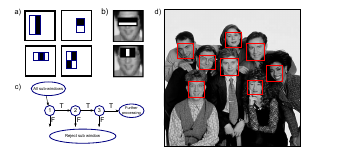
a) Each weak classiﬁer consists of the response of the image to a Haar- like ﬁlter, which is then passed through a step function. b) The ﬁrst two weak classiﬁers learned in this implementation have clear interpretations: the ﬁrst responds to the dark horizontal region belonging to the eyes and the second responds to the relative brightness of the bridge of the nose. c) The data passes through a cascade: most regions can be quickly rejected after evaluating only a few weak classiﬁers as they look nothing like faces. More ambiguous regions undergo further preprocessing. d) Example results. Adapted from Viola & Jones (2004).

In [3]:
import numpy as np
from scipy.special import expit  # Sigmoid function for logistic regression

def gender_classification(features, phi_0, phi_k, xi_k):
    """
    Performs gender classification using the logistic regression model described.

    Args:
        features (numpy.ndarray): Feature vector (x_i) of shape (D,).
        phi_0 (float): Bias term.
        phi_k (numpy.ndarray): Coefficients (phi_k) of shape (K,).
        xi_k (numpy.ndarray): Projection vectors (xi_k) of shape (K, D+1).

    Returns:
        float: Probability of the image containing a female face (w_i = 1).
    """
    
    # Augment the feature vector with 1
    features_augmented = np.concatenate(([1], features))
    
    # Calculate f[x_i, xi_k]
    f_values = np.arctan(np.dot(xi_k, features_augmented))

    # Calculate the linear combination
    linear_combination = phi_0 + np.sum(phi_k * f_values)

    # Calculate the probability using the sigmoid function
    probability = expit(linear_combination)

    return probability

# Example Usage (Illustrative)
# Assuming D = 1064, K = 300
D = 1064
K = 300

# Generate some example features (replace with actual feature extraction)
example_features = np.random.randn(D)

# Generate some random parameters (replace with learned parameters)
phi_0_example = np.random.randn()
phi_k_example = np.random.randn(K)
xi_k_example = np.random.randn(K, D + 1)

# Perform classification
probability_female = gender_classification(example_features, phi_0_example, phi_k_example, xi_k_example)

print(f"Probability of female face: {probability_female}")

# Example of how to determine the predicted gender.
def predicted_gender(probability):
  if probability >0.5:
    return "Female"
  else:
    return "Male"

predicted_gender_result = predicted_gender(probability_female)
print(f"Predicted gender: {predicted_gender_result}")

Probability of female face: 0.996532654021118
Predicted gender: Female


In [4]:
import math

def sigmoid(x):
    """Calculates the sigmoid function."""
    return 1 / (1 + math.exp(-x))

def gender_classification(features, phi_0, phi_k, xi_k):
    """
    Performs gender classification using the logistic regression model described.

    Args:
        features (list): Feature vector (x_i) of floats.
        phi_0 (float): Bias term.
        phi_k (list): Coefficients (phi_k) of floats.
        xi_k (list): Projection vectors (xi_k) of lists of floats.

    Returns:
        float: Probability of the image containing a female face (w_i = 1).
    """

    # Augment the feature vector with 1
    features_augmented = [1.0] + features

    # Calculate f[x_i, xi_k]
    f_values = []
    for xi in xi_k:
        dot_product = 0.0
        for i in range(len(xi)):
            dot_product += xi[i] * features_augmented[i]
        f_values.append(math.atan(dot_product))

    # Calculate the linear combination
    linear_combination = phi_0
    for i in range(len(phi_k)):
        linear_combination += phi_k[i] * f_values[i]

    # Calculate the probability using the sigmoid function
    probability = sigmoid(linear_combination)

    return probability

# Example Usage (Illustrative)
# Assuming D = 1064, K = 300
D = 1064
K = 300

# Generate some example features (replace with actual feature extraction)
example_features = [0.1 * (i % 10) for i in range(D)] #example list of floats

# Generate some random parameters (replace with learned parameters)
phi_0_example = 0.5
phi_k_example = [0.01 * (i % 10) for i in range(K)] #example list of floats
xi_k_example = [[0.001 * (i + j) % 10 for i in range(D + 1)] for j in range(K)] #example list of lists of floats.

# Perform classification
probability_female = gender_classification(example_features, phi_0_example, phi_k_example, xi_k_example)

print(f"Probability of female face: {probability_female}")

# Example of how to determine the predicted gender.
def predicted_gender(probability):
  if probability >0.5:
    return "Female"
  else:
    return "Male"

predicted_gender_result = predicted_gender(probability_female)
print(f"Predicted gender: {predicted_gender_result}")

Probability of female face: 0.9999999996095736
Predicted gender: Female


## Face and Pedestrian Detection using Boosting

This section discusses the application of boosting algorithms for face and pedestrian detection, focusing on the work of Viola and Jones.

### Face Detection (Viola & Jones, 2004)

* **Data Representation:**
    * Image patches of size 24 × 24 pixels.
    * Data vector $x$ is prepended with a 1 for offset.
* **Training Data:**
    * 5,000 face images.
    * 10,000 non-face region images.
* **Model:**
    * Boosting algorithm with a large number of pre-defined projections $\xi_k$.
    * Non-smooth step function, making gradient-based optimization unsuitable.
    * Exhaustive search for optimal projections.
* **Speed Optimization:**
    1.  **Cascade Structure:**
        * Incremental training of 'weak classifiers' to form a 'strong classifier'.
        * Early rejection of non-face regions using initial weak classifiers.
        * Later cascade stages trained with false positives from earlier stages.
    2.  **Fast Feature Evaluation:**
        * Haar-like filters (section 11.4.4) for efficient projection computation.
* **Results:**
    * 4297 weak classifiers in a 32-stage cascade.
    * 91.1% detection rate on 507 frontal faces across 130 images.
    * False positive rate less than 1 per frame.
    * Real-time processing.

### Pedestrian Detection (Viola et al., 2005)

* **Extension of Face Detection System:**
    * Adapted for pedestrian detection in video sequences.
* **Modification:**
    * Extended weak classifiers to include temporal features.
    * Used image data, difference images between frames, and offset difference images.
* **Results:**
    * 80% detection rate.
    * False alarm rate of 1/400,000 (one false positive per two frames).

### Semantic Segmentation (Shotton et al., 2009)

* **Goal:**
    * Assign a label $w \in \{1 ... M\}$ to each pixel, indicating the object present.
* **Method:**
    * Textonboost system based on the jointboost algorithm.
    * One-against-all strategy with $M$ binary classifiers.
    * The decision is based on the weighted sums:
    $$ a_m = \phi_{0m} + \sum_{k=1}^{K} \phi_{km} f[x, \xi_k] $$
    * Where $a_m$ represents the activation for class m.
    
    ## Pedestrian Detection and Semantic Segmentation using Boosting

This section delves into the application of boosting methods for pedestrian detection in video and semantic segmentation, building upon the concepts introduced earlier.

### Pedestrian Detection (Viola et al., 2005)

* **Temporal Feature Integration:**
    * To enhance detection rates, two consecutive frames (Frame 1 and Frame 2) are utilized.
    * Difference images are computed:
        * Absolute difference between Frame 1 and Frame 2.
        * Difference when Frame 1 is offset in four directions (Up, Down, Left, Right) relative to Frame 2.
    * Haar-like filters are applied to all six representations (Frame 1, Frame 2, and the four difference images).
* **Visual Representation:**
    * **a)** Illustration of the frame differencing and offsetting process.
    * **b, c)** Example detection results showcasing the system's performance.
* **Model:**
    * Boosting methods based on thresholded responses of Haar functions.

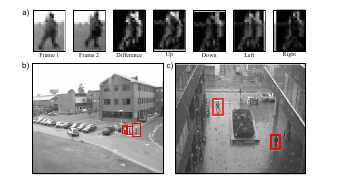

Functions have also been used for pedestrian detection in video footage. a) To improve detection rates two subsequent frames are used. The absolute diﬀerence between the frames is computed as is the diﬀerence when one of the frames is oﬀset in each of four directions. The set of potential weak classiﬁers consists of Haar functions applied to all six of these representations. b,c) Example results. Adapted from Viola et al. (2005). 


* **Figure 9.21:**
    * Visual representation of the process described above.
    * Adapted from Viola et al. (2005). ©2005c Springer.

### Semantic Segmentation (Shotton et al., 2009)

* **Goal:**
    * Assign a label $w \in \{1 ... M\}$ to each pixel, indicating the object class.
* **Method:**
    * Textonboost system using jointboost.
    * The decision is based on weighted sums:
    $$ a_m = \phi_{0m} + \sum_{k=1}^{K} \phi_{km} f[x, \xi_k] $$
    * Where $f[\cdot]$ are based on Heaviside step functions.
    * Decision is made based on the maximum activation $a_m$.
* **Texton Representation:**
    * Pixels are replaced with discrete indices representing texture types (textons).
    * Nonlinear functions count texton occurrences within rectangular areas at fixed spatial displacements.
        * Zero displacement: Direct pixel evidence (e.g., grass).
        * Non-zero displacement: Local context evidence (e.g., grass nearby, suggesting a cow).
    * An offset is added to texton counts, and the result is passed through a step function.
* **Learning:**
    * Incremental learning by evaluating random classifiers (texton, region, offset) and selecting the best.
* **Post-processing:**
    * Result refinement using a conditional random field (CRF) model (chapter 12).
* **Performance:**
    * Achieved 72.2% accuracy.
* **Figure 9.22 c-f:**
    * Visual representation of the spatial displacement of the rectangular area in the texton representation.
    
    

## Semantic Image Labeling using TextonBoost (Shotton et al., 2009)

This section details the TextonBoost method for semantic image labeling, focusing on its components and performance.

**Method Overview:**

* **TextonBoost:** A system for semantic image labeling based on boosting.
* **Goal:** To assign a label to each pixel, indicating the object class it belongs to.

**Process Breakdown:**

* **a) Original Image:** The input image.
* **b) Texton Conversion:**
    * The original image is transformed into a texton representation.
    * Each pixel is assigned a discrete value, representing the local texture type (texton).
* **c) Weak Classifiers:**
    * The system uses weak classifiers that count the number of textons of a specific type within a rectangular region.
    * This rectangle is offset from the pixel being classified (indicated by the yellow cross).
* **d) Contextual Information:**
    * These weak classifiers provide information about both the object itself (e.g., sheep-like textons) and its surrounding context (e.g., grass-like textons nearby).
* **e, f) Example Weak Classifier:**
    * Further examples of how the weak classifiers function.
* **g) Test Image:** An image used for testing the system.
* **h) Per-Pixel Classification:**
    * Initial per-pixel classification results, which may have imprecise object boundaries.
* **i) Conditional Random Field (CRF) Refinement:**
    * A CRF model is employed to improve the accuracy of the classification, particularly at object edges.
* **j) Results and Ground Truth:**
    * Examples of the system's final results compared to the ground truth labels.
* **Figure 22:**
    * Visual representation of the TextonBoost process.
    * Adapted from Shotton et al. (2009). ©2009 Springer.

**Performance:**

* **Accuracy:** Achieved 72.2% performance on the challenging MRSC database.
* **Database Characteristics:**
    * Includes 21 diverse object classes.
    * Contains objects with complex structures (e.g., bicycles) and high variability (e.g., dogs).

In [6]:
import math
import random

def textonboost_segmentation(image, texton_image, num_classes, num_weak_classifiers, num_iterations):
    """
    Simulates the TextonBoost semantic segmentation process.

    Args:
        image (list of lists): The original image (for context).
        texton_image (list of lists): The image represented as texton indices.
        num_classes (int): The number of object classes.
        num_weak_classifiers (int): The number of weak classifiers.
        num_iterations (int): Number of boosting iterations.

    Returns:
        list of lists: The segmented image (pixel labels).
    """

    height = len(texton_image)
    width = len(texton_image[0])
    pixel_labels = [[0 for _ in range(width)] for _ in range(height)]  # Initialize pixel labels
    class_activations = [[[0.0 for _ in range(num_classes)] for _ in range(width)] for _ in range(height)] #activations for each class
    weak_classifiers = []

    def count_textons_in_rectangle(x, y, texton_type, offset_x, offset_y, rectangle_width, rectangle_height):
        """Counts textons of a given type within a rectangular region."""
        count = 0
        for i in range(rectangle_height):
            for j in range(rectangle_width):
                px = x + j + offset_x
                py = y + i + offset_y
                if 0 <= px < width and 0 <= py < height and texton_image[py][px] == texton_type:
                    count += 1
        return count

    def weak_classifier(x, y, texton_type, offset_x, offset_y, rectangle_width, rectangle_height, offset):
        """Simulates a weak classifier based on texton counts."""
        count = count_textons_in_rectangle(x, y, texton_type, offset_x, offset_y, rectangle_width, rectangle_height)
        return 1 if count + offset > 0 else 0

    def select_best_classifier(weights):
        """Simulates selecting the best weak classifier based on weighted error."""
        best_classifier = None
        min_error = float('inf')
        for _ in range(num_weak_classifiers):
            texton_type = random.randint(0, max(max(row) for row in texton_image)) #assumes texton labels start at 0
            offset_x = random.randint(-5, 5)
            offset_y = random.randint(-5, 5)
            rectangle_width = random.randint(1, 10)
            rectangle_height = random.randint(1, 10)
            offset = random.randint(-5, 5)

            error = 0.0
            for y in range(height):
                for x in range(width):
                    #simulated ground truth. this is a critical part of a real implementation.
                    ground_truth_class = random.randint(0, num_classes-1)
                    prediction = weak_classifier(x, y, texton_type, offset_x, offset_y, rectangle_width, rectangle_height, offset)
                    if prediction != (1 if ground_truth_class == 1 else 0): #example of binary classification.
                        error += weights[y][x]
            if error < min_error:
                min_error = error
                best_classifier = (texton_type, offset_x, offset_y, rectangle_width, rectangle_height, offset)

        return best_classifier

    weights = [[1.0 / (height * width) for _ in range(width)] for _ in range(height)]

    for _ in range(num_iterations):
        best_classifier_params = select_best_classifier(weights)
        if best_classifier_params is None:
          break;

        weak_classifiers.append(best_classifier_params)
        texton_type, offset_x, offset_y, rectangle_width, rectangle_height, offset = best_classifier_params

        alpha = 1.0 #simplified alpha

        for y in range(height):
            for x in range(width):
                 prediction = weak_classifier(x, y, texton_type, offset_x, offset_y, rectangle_width, rectangle_height, offset)
                 #simulated ground truth.
                 ground_truth_class = random.randint(0, num_classes-1)

                 if prediction != (1 if ground_truth_class == 1 else 0):
                    weights[y][x] = weights[y][x] * math.exp(alpha)
                 else:
                    weights[y][x] = weights[y][x] * math.exp(-alpha)

        total_weight = sum(sum(row) for row in weights)
        for y in range(height):
            for x in range(width):
                weights[y][x] /= total_weight

    # Final Classification (simplified)
    for y in range(height):
        for x in range(width):
            class_activations_pixel = [0.0] * num_classes
            for classifier_params in weak_classifiers:
                texton_type, offset_x, offset_y, rectangle_width, rectangle_height, offset = classifier_params
                prediction = weak_classifier(x, y, texton_type, offset_x, offset_y, rectangle_width, rectangle_height, offset)
                for class_index in range(num_classes):
                  if prediction == 1:
                    class_activations_pixel[class_index] += 1
            pixel_labels[y][x] = class_activations_pixel.index(max(class_activations_pixel))

    return pixel_labels